In [ ]:
"""installs"""

# !pip install nc-time-axis
# !pip install netCDF4 h5netcdf
# !pip install xarray
# !pip install cdsapi
# !pip install networkx geopandas osmnx igraph matplotlib
# !pip install pysal scikit-learn libpysal tobler geopandas numpy pandas networkx
# !pip install access
# !pip install transliterate


'installs'

In [ ]:
import sys
from pathlib import Path

# Add parent directory to Python path to enable imports from scripts/
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)


In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import networkx as nx
from shapely.geometry import Polygon, MultiPolygon
import requests
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from tqdm import tqdm

import pandas as pd
from transliterate import translit
import scripts_old.model as model
import scripts_old.provision as provision
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import os
from tqdm import tqdm

tqdm.pandas()


## 0. Main imports & definitions

In [ ]:
"""
winter_tr -- это должно быть зимники?
"""

KELVIN_TO_CELSIUS = 273.15

# ??????????????????
UTM_CRS = 2693
MINUTES_IN_HOUR = 60

DEMAND_COL = "demand_without"
SERVICE_NAME = "hospital"
SETTL_NAME = "yakut_chuk"
CONST_BASE_DEMAND = 120  # if not known (!)
SERVICE_RADIUS_MINUTES = 60 * 13
DEGREE_CRS = 4326
START_YEAR = 1982
MONTHS_IN_YEAR = 12
END_YEAR = 2024
CLIMATE_DATA_FILE_NAME = f"df_climate_{SETTL_NAME}.csv"

# Параметры
start_date = str(START_YEAR) + "0101"
end_date = str(END_YEAR) + "1201"
parameters = "T2M"

threshold = 0.55


# Пороговые температуры
thresholds = {
    "Aviation": -44.6,
    "Winter unique road": -11.2,
    "Water transport_ship": 0.3,
    "Regular road": 7.3,
}

transport_modes = [
    "Regular road",
    "Aviation",
    "Water transport_ship",
    "Water transport_boat",
    "Winter only road",
    "Winter unique road",
]

# 1. #f5ccaf  → light peach (service node)
# 2. #cfddd9  → pale teal/gray (city node)
# 3. #3b67b6  → blue (water transport)
# 4. #9e77b7  → violet (winter-only road)
# 5. #dd8da3  → pink (aviation)
# 6. #b28d6f  → brown (regular road)
# 7. #f7f6f2  → background/off-white
# 8. #2e2e2e  → black/dark gray (text and outlines)
# 9. #f1a742  → orange (temperature annotation)
# 10. #809ec2 → steel blue (blended edge?)


mode_colors = {
    "Aviation": "#dd8da3",
    "Regular road": "#b28d6f",
    "Winter unique road": "#6f0faa",
    "Winter only road": "#9e77b7",
    "Water transport_boat": "#3b67b6",
    "Water transport_ship": "#0340b1",
}

# Упорядочим месяцы
month_order = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

data_path = "../data/processed/"


In [ ]:
def sigmoid(x, center, steepness=1):
    """
    Sigmoid function for smooth probability transition
    center: temperature at which probability is 0.5
    steepness: controls how sharp the transition is
    """
    return 1 / (1 + np.exp(-steepness * (x - center)))


def get_transport_probability(transport_type, temperature):
    """
    Calculate transport probability based on temperature using smooth transitions
    """
    if transport_type == "Aviation":
        # Planes work better in warmer weather, degrading below -10°C
        return np.round(sigmoid(temperature, -45, 0.5), 5)

    elif transport_type in ["Water transport_ship", "Water transport_boat"]:
        # Water transport needs above-freezing temperatures
        return np.round(sigmoid(temperature, 0, 0.8), 5)

    elif transport_type == "Regular road":
        # Regular cars work better in warm weather
        return np.round(sigmoid(temperature, 7, 0.7), 5)

    elif transport_type in ["Winter only road", "Winter unique road"]:
        # Winter transport works better in cold weather
        return 1 - np.round(sigmoid(temperature, -11, 1), 5)

    return -1e6


## 1. Data reading & cleaning

In [ ]:
settl = gpd.read_file(data_path + f"df_settlements_{SETTL_NAME}.geojson").to_crs(
    UTM_CRS
)
settl["name"] = settl["name"].str.replace("ё", "е")
settl.geometry = settl.geometry.buffer(1e3)


In [ ]:
transport_df = (
    gpd.read_file(data_path + f"df_time_{SETTL_NAME}.geojson")
    .to_crs(UTM_CRS)
    .dropna(subset=["geometry"])
)


transport_df.rename(
    columns={
        "car_warm": "Regular road",
        "plane": "Aviation",
        "water_ship": "Water transport_ship",
        "water_boat": "Water transport_boat",
        "car_cold": "Winter only road",
        "winter_tr": "Winter unique road",
    },
    inplace=True,
)


# Convert mode values from ',' to '.' and ensure t≠hey are float
for mode in transport_modes:
    transport_df[mode] = (
        transport_df[mode].astype(str).str.replace(",", ".").astype(float)
    )
transport_df["edge1"] = transport_df["edge1"].str.replace("ё", "е")
transport_df["edge2"] = transport_df["edge2"].str.replace("ё", "е")


In [ ]:
transport_df[transport_modes] *= MINUTES_IN_HOUR  # convert from hours to minutes
transport_df[transport_modes] = transport_df[transport_modes].round(0)


In [ ]:
infr_df = pd.read_csv(data_path + f"infrastructure_{SETTL_NAME}.csv", sep=";")
# Fill NaNs with 0
infr_df.fillna(0, inplace=True)
infr_df["name"] = infr_df["name"].str.replace("ё", "е")


In [ ]:
df_service = gpd.read_file(
    data_path + f"df_{SERVICE_NAME}_{SETTL_NAME}.geojson"
).to_crs(UTM_CRS)

df_service["name"] = df_service["name"].str.replace("ё", "е")


# 2. Preprocessing

### 2.1 Blocks scheme creation

In [ ]:
blocks_gdf = model.create_blocks(settl, const_demand=CONST_BASE_DEMAND, epsg=UTM_CRS)
blocks_gdf = model.update_blocks_with_services(
    blocks_gdf, df_service, service_type=SERVICE_NAME
)


In [ ]:
# Добавим колонку с транслитерированными именами
blocks_gdf["name"] = blocks_gdf["name"].apply(
    lambda x: translit(x, "ru", reversed=True)
)
transport_df["edge1"] = transport_df["edge1"].apply(
    lambda x: translit(x, "ru", reversed=True)
)
transport_df["edge2"] = transport_df["edge2"].apply(
    lambda x: translit(x, "ru", reversed=True)
)


### 2.2 Graph creation

In [ ]:
transport_df.drop(columns=["mean_time", "winter", "water"], inplace=True)


In [ ]:
def fix_missing_capacity(row):
    """this is just a very straight forward workaround"""
    if row["population"] > 10e3 and row["capacity_hospital"] == 0:
        row["capacity_hospital"] = row["population"] / 10

    return int(row["capacity_hospital"])


blocks_gdf["capacity_hospital"] = blocks_gdf.apply(fix_missing_capacity, axis=1)


In [ ]:
blocks_gdf


,id,name,geometry,population,epsg,capacity_hospital
0,0,Aleko-Kjuel',"POLYGON ((58505505.484 7829190.457, 58505500.6...",512,2693,500
1,1,Andrjushkino,"POLYGON ((58623109.664 7840844.823, 58623104.8...",741,2693,1000
2,2,Anjujsk,"POLYGON ((58870427.938 7664076.161, 58870423.1...",380,2693,1000
3,3,Argahtah,"POLYGON ((58552171.503 7780684.823, 58552166.6...",469,2693,500
4,4,Berezovka,"POLYGON ((58628367.942 7594155.884, 58628363.1...",280,2693,500
5,5,Bilibino,"POLYGON ((59062296.508 7589776.239, 59062291.6...",5449,2693,0
6,6,Dve Viski,"POLYGON ((58838756.805 7674333.53, 58838751.98...",120,2693,0
7,7,Ermolovo,"POLYGON ((58831562.337 7690390.324, 58831557.5...",120,2693,0
8,8,Ilirnej,"POLYGON ((59111931.671 7491346.26, 59111926.85...",188,2693,500
9,9,Keperveem,"POLYGON ((59045667.96 7568441.424, 59045663.14...",341,2693,500


In [ ]:
transport_df


,edge1,edge2,Regular road,Aviation,Water transport_ship,Water transport_boat,Winter only road,Winter unique road,geometry
0,Aleko-Kjuel',Bilibino,0.0,0.0,0.0,0.0,0.0,2194.0,"LINESTRING (58504565.15 7829260.532, 59061356...."
1,Aleko-Kjuel',Svataj,0.0,0.0,0.0,0.0,0.0,264.0,"LINESTRING (58504966.699 7827013.99, 58473476...."
2,Andrjushkino,Aleko-Kjuel',0.0,0.0,0.0,0.0,0.0,780.0,"LINESTRING (58504514.42 7829150.568, 58622277...."
3,Andrjushkino,Argahtah,0.0,0.0,0.0,0.0,0.0,216.0,"LINESTRING (58551181.916 7780504.604, 58622200..."
4,Andrjushkino,Bilibino,0.0,0.0,0.0,0.0,0.0,1422.0,"LINESTRING (59061252.914 7589864.605, 58622136..."
...,...,...,...,...,...,...,...,...,...
156,Cherskij,Sylgy-Ytar,0.0,0.0,0.0,0.0,0.0,1532.0,"LINESTRING (58583233.907 7696401.734, 58871646..."
157,Cherskij,Ebjah,0.0,0.0,0.0,0.0,0.0,1621.0,"LINESTRING (58871723.449 7710535.768, 58448499..."
159,Ebjah,Aleko-Kjuel',0.0,0.0,0.0,0.0,0.0,413.0,"LINESTRING (58448809.211 7819366.701, 58504712..."
160,Ebjah,Bilibino,0.0,0.0,0.0,0.0,0.0,2164.0,"LINESTRING (58448686.183 7818976.581, 59061298..."


In [ ]:
# Convert G to an undirected graph
G_undirected = nx.MultiGraph()

# Add edges from transport_df
for _, row in transport_df.iterrows():
    for mode in transport_modes:
        if row[mode] != 0:
            G_undirected.add_edge(
                row["edge1"],
                row["edge2"],
                weight=round(row[mode], 2),
                label=mode,
            )

            G_undirected.add_edge(
                row["edge2"],
                row["edge1"],
                weight=round(row[mode], 2),
                label=mode,
            )

# Add node properties from blocks_gdf dataframe
for _, row in blocks_gdf.iterrows():
    node = row["name"]
    if node in G_undirected.nodes:
        for col in blocks_gdf.columns:
            # if col != "geometry":  # Skip geometry column
            G_undirected.nodes[node][col] = row[col]

            if col == "geometry":
                # Convert geometry to WKT format
                geom = row[col]
                if geom is not None:
                    G_undirected.nodes[node]["x"] = geom.centroid.x
                    G_undirected.nodes[node]["y"] = geom.centroid.y
                else:
                    G_undirected.nodes[node]["x"] = None
                    G_undirected.nodes[node]["y"] = None

G_undirected.graph["crs"] = settl.crs.to_epsg()


In [ ]:
def plot_transport_graph(G, figsize=(14, 10), title="Transport Graph with modes"):
    fig, ax = plt.subplots(figsize=figsize)

    patches = []

    # Рисуем полигоны узлов (фон)
    for n, d in G.nodes(data=True):
        geom = d.get("geometry")
        if isinstance(geom, Polygon) and not geom.is_empty:
            patches.append(MplPolygon(list(geom.exterior.coords), closed=True))
        elif isinstance(geom, MultiPolygon):
            for part in geom.geoms:
                if isinstance(part, Polygon) and not part.is_empty:
                    patches.append(MplPolygon(list(part.exterior.coords), closed=True))

    if patches:
        pc = PatchCollection(patches, facecolor="#eeeeee", edgecolor="black", alpha=0.5)
        ax.add_collection(pc)

    # Позиции узлов
    pos = {n: (d.get("x"), d.get("y")) for n, d in G.nodes(data=True)}

    # Цвета для разных транспортных мод

    # Рисуем рёбра разными цветами
    for u, v, data in G.edges(data=True):
        label = data.get("label")
        color = mode_colors.get(label, "gray")
        if pos[u] is not None and pos[v] is not None:
            x_values = [pos[u][0], pos[v][0]]
            y_values = [pos[u][1], pos[v][1]]
            ax.plot(x_values, y_values, color=color, alpha=0.7, linewidth=1.5)

    # Рисуем узлы
    nx.draw_networkx_nodes(
        G, pos, node_size=50, node_color="#ffcc00", edgecolors="black", ax=ax
    )

    # Подписи узлов
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    # Легенда для видов транспорта
    handles = [
        plt.Line2D([0], [0], color=color, lw=2, label=label)
        for label, color in mode_colors.items()
    ]
    ax.legend(handles=handles, title="Transport mode", loc="upper right", fontsize=10)

    ax.set_title(title, fontsize=16)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


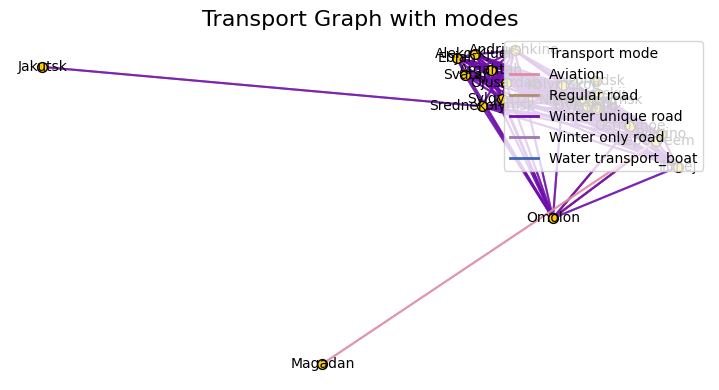

In [ ]:
plot_transport_graph(G_undirected, figsize=(14, 4), title="Transport Graph with modes")


### 2.4.0 nasa

In [ ]:
"""берем нижнюю и верхнюю температуры"""

# Приводим к WGS84
blocks_gdf = blocks_gdf.to_crs(DEGREE_CRS)


# Папка для кэша
output_dir = "../data/climate_data_blocks"
Path(output_dir).mkdir(exist_ok=True, parents=True)

if CLIMATE_DATA_FILE_NAME in os.listdir(data_path):
    df_climate = pd.read_csv(data_path + CLIMATE_DATA_FILE_NAME, index_col=0)

else:
    # Будем собирать результаты
    climate_results = []

    for idx, row in tqdm(blocks_gdf.iterrows(), total=len(blocks_gdf)):
        name = row["name"]
        centroid: Point = row["geometry"].centroid
        lon, lat = centroid.x, centroid.y

        out_file = os.path.join(output_dir, f"{name}_{start_date}_{end_date}.json")

        if os.path.exists(out_file):
            with open(out_file, "r") as f:
                data = json.load(f)
        else:
            url = (
                f"https://power.larc.nasa.gov/api/temporal/daily/point"
                f"?parameters={parameters}"
                f"&community=RE"
                f"&longitude={lon}&latitude={lat}"
                f"&start={start_date}&end={end_date}"
                f"&format=JSON"
            )
            r = requests.get(url)
            r.raise_for_status()
            data = r.json()
            with open(out_file, "w") as f:
                json.dump(data, f)

        temperature = data["properties"]["parameter"]["T2M"]

        climate_results.append(
            {"name": name, "lon": lon, "lat": lat, "temperature": temperature}
        )

    df_climate = pd.DataFrame(climate_results)
    df_climate.to_csv(data_path + CLIMATE_DATA_FILE_NAME)


In [ ]:
climate_records = []

for _, row in df_climate.iterrows():
    name = row["name"]
    lon = row["lon"]
    lat = row["lat"]
    try:
        temp_dict = eval(row["temperature"])
    except Exception:
        temp_dict = row["temperature"]

    # Convert dict to Series → DataFrame
    temp_series = pd.Series(temp_dict).astype(float)
    temp_series.index = pd.to_datetime(temp_series.index, format="%Y%m%d")
    temp_df = temp_series.rename("temperature").reset_index()
    temp_df = temp_df.rename(columns={"index": "date"})

    # Compute month
    temp_df["month"] = temp_df["date"].dt.to_period("M")

    # Group and convert to list
    monthly_avg = (
        temp_df.groupby("month")["temperature"]
        .mean()
        .sort_index()
        .tolist()  # 👈 collapse to list
    )

    climate_records.append(
        {
            "name": name,
            "lon": lon,
            "lat": lat,
            "monthly_temperature": [int(round(x)) for x in monthly_avg],  # round to int
        }
    )

df_monthly_list = pd.DataFrame(climate_records)


In [ ]:
for node in G_undirected.nodes:
    if (
        G_undirected.nodes[node]["x"] is not None
        and G_undirected.nodes[node]["y"] is not None
    ):
        name = G_undirected.nodes[node]["name"]

        # Extract temperature data for the node's coordinates
        city_temp = df_monthly_list[df_monthly_list["name"] == name][
            "monthly_temperature"
        ].squeeze()
        G_undirected.nodes[node]["temperature"] = pd.DataFrame(
            city_temp, columns=["temperature"]
        ).round(0)

        # G_undirected.nodes[node]["season"] = G_undirected.nodes[node][
        #     "temperature"
        # ].map(get_season_by_temperature)


# 4. Ok so to the modelling again...

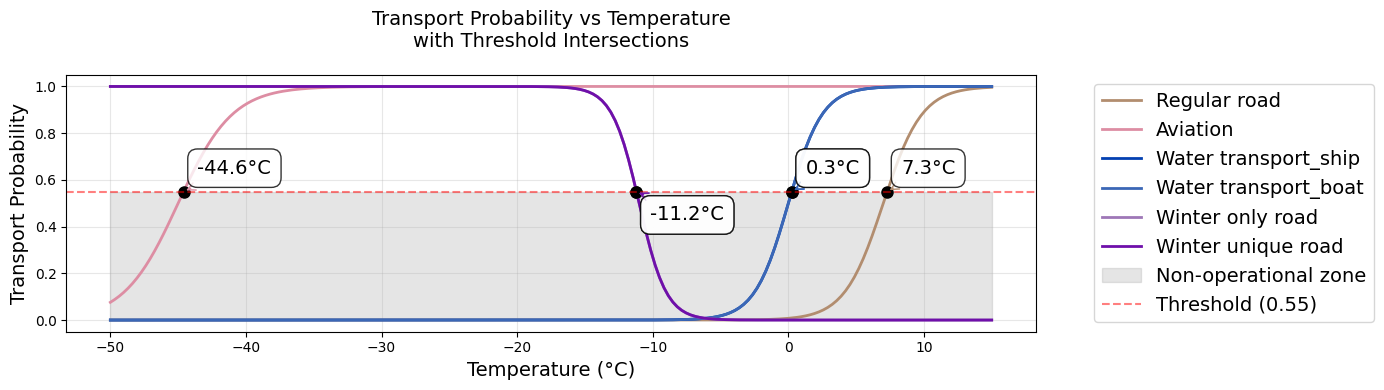

In [ ]:
# Create temperature range and transport types
temps = np.linspace(-50, 15, 200)


# Create figure with increased size
plt.figure(figsize=(14, 4))

# Plot probability curves and find threshold intersections
for t_type in transport_modes:
    probs = [get_transport_probability(t_type, t) for t in temps]
    (line,) = plt.plot(
        temps, probs, label=t_type, linewidth=2, color=mode_colors[t_type]
    )

    # Find intersection points with threshold
    for i in range(len(temps) - 1):
        if (probs[i] - threshold) * (probs[i + 1] - threshold) <= 0:
            # Linear interpolation to find exact intersection
            t_intersect = temps[i] + (temps[i + 1] - temps[i]) * (
                threshold - probs[i]
            ) / (probs[i + 1] - probs[i])
            plt.plot(t_intersect, threshold, "ko", markersize=8)
            plt.annotate(
                f"{t_intersect:.1f}°C",
                (t_intersect, threshold),
                xytext=(10, 10 if probs[i] < threshold else -10),
                textcoords="offset points",
                ha="left",
                va="bottom" if probs[i] < threshold else "top",
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                arrowprops=dict(arrowstyle="->", color=line.get_color()),
                fontsize=14,
            )

# Add grey shading for area below threshold
plt.fill_between(
    temps, 0, threshold, color="grey", alpha=0.2, label="Non-operational zone"
)


# Add threshold line
plt.axhline(
    y=threshold, color="r", linestyle="--", alpha=0.5, label=f"Threshold ({threshold})"
)

plt.xlabel("Temperature (°C)", fontsize=14)
plt.ylabel("Transport Probability", fontsize=14)
plt.title(
    "Transport Probability vs Temperature\nwith Threshold Intersections",
    fontsize=14,
    pad=20,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### The main calculations

In [ ]:
class Statistics:
    def __init__(self):
        self.records = pd.DataFrame(
            columns=[
                "idx",
                "mean",
                "min",
                "max",
                "median",
            ]
        )
        self.graphs = list()
        self.results = list()

    def add_record(self, step_index, metrics: dict, G, result):
        new_row = pd.DataFrame(
            [
                {
                    "idx": step_index,
                    "mean": metrics.get("mean"),
                    "min": metrics.get("min"),
                    "max": metrics.get("max"),
                    "median": metrics.get("median"),
                }
            ]
        )
        self.records = pd.concat([self.records, new_row], ignore_index=True)
        self.graphs.append(G)
        self.results.append(result)

    def summary(self):
        return self.records.pivot_table(index="idx", columns="col", values="mean")

    def full(self):
        return self.records


class AgglomerationNetwork:
    def __init__(self, graph, threshold):
        self.original_graph = graph.copy()
        self.graph = graph.copy()
        self.threshold = threshold
        self.stats = Statistics()
        self.current_step = 0  # Initialize current_step

    def _get_edge_temperature(self, G, u, v, idx, key):
        """
        RULE: least suitable temperature of the two nodes
        тк большинсво связей это самолеты(?)
        """

        temp_u = G.nodes[u].get("temperature").loc[idx].item()
        temp_v = G.nodes[v].get("temperature").loc[idx].item()

        if G.edges[u, v, key]["label"] in ["car_cold", "winter_tr"]:
            return np.round(np.max([temp_u, temp_v]), 1)
        else:
            return np.round(np.min([temp_u, temp_v]), 1)

    def assign_edge_temperatures(self, G, idx):
        for u, v, key in G.edges(keys=True):
            G.edges[u, v, key]["temperature"] = self._get_edge_temperature(
                G, u, v, idx, key
            )

        return G

    def assign_transport_probabilities(self, G):
        """
        Assigns smooth transport probabilities based on temperature
        """
        for _, _, data in G.edges(data=True):
            transport_type = data.get("label")
            temperature = data.get("temperature")
            if transport_type and temperature:
                data["transport_probability"] = get_transport_probability(
                    transport_type, temperature
                )
            else:
                data["transport_probability"] = -1e3

    def filter_edges_by_probability(self, G, threshold):
        """
        Возвращает копию графа G, содержащую только те рёбра,
        у которых transport_probability >= threshold
        """
        G_filtered = nx.Graph()
        G_filtered.add_nodes_from(G.nodes(data=True))

        for u, v, data in G.edges(data=True):
            # print(f"edge: {u} - {v}, data: {data}")
            prob = data.get("transport_probability", 0.0)
            if prob >= threshold:
                G_filtered.add_edge(u, v, **data)
        G_filtered.graph["crs"] = G.graph["crs"]
        return G_filtered

    def run_all_steps(self, idx):
        self.current_step = idx  # Update current_step
        self.assign_edge_temperatures(self.graph, idx)
        self.assign_transport_probabilities(self.graph)
        G_filtered = self.filter_edges_by_probability(
            self.graph, threshold=self.threshold
        )

        G, result, A = provision.calculate_graph_provision(
            G_filtered,
            SERVICE_RADIUS_MINUTES,
            CONST_BASE_DEMAND,
            service_name=SERVICE_NAME,
            return_assignment=True,
        )

        # display(result)

        avg_provision = result["provision"].mean().round(2)
        min_provision = result["provision"].min().round(2)
        max_provision = result["provision"].max().round(2)
        median_provision = result["provision"].median().round(2)

        other_metrics = {
            "mean": avg_provision,
            "min": min_provision,
            "max": max_provision,
            "median": median_provision,
        }
        metrics = {**other_metrics}

        self.stats.add_record(step_index=idx, metrics=metrics, G=G, result=result)


net = AgglomerationNetwork(graph=G_undirected, threshold=threshold)

range_year = range(list(G_undirected.nodes(data=True))[0][1]["temperature"].shape[0])

for idx in tqdm(range_year):
    net.run_all_steps(idx)

df_stats = net.stats.records


100%|██████████| 516/516 [00:30<00:00, 16.77it/s]


### Visuals of main calcs

/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_3366/1444077075.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])


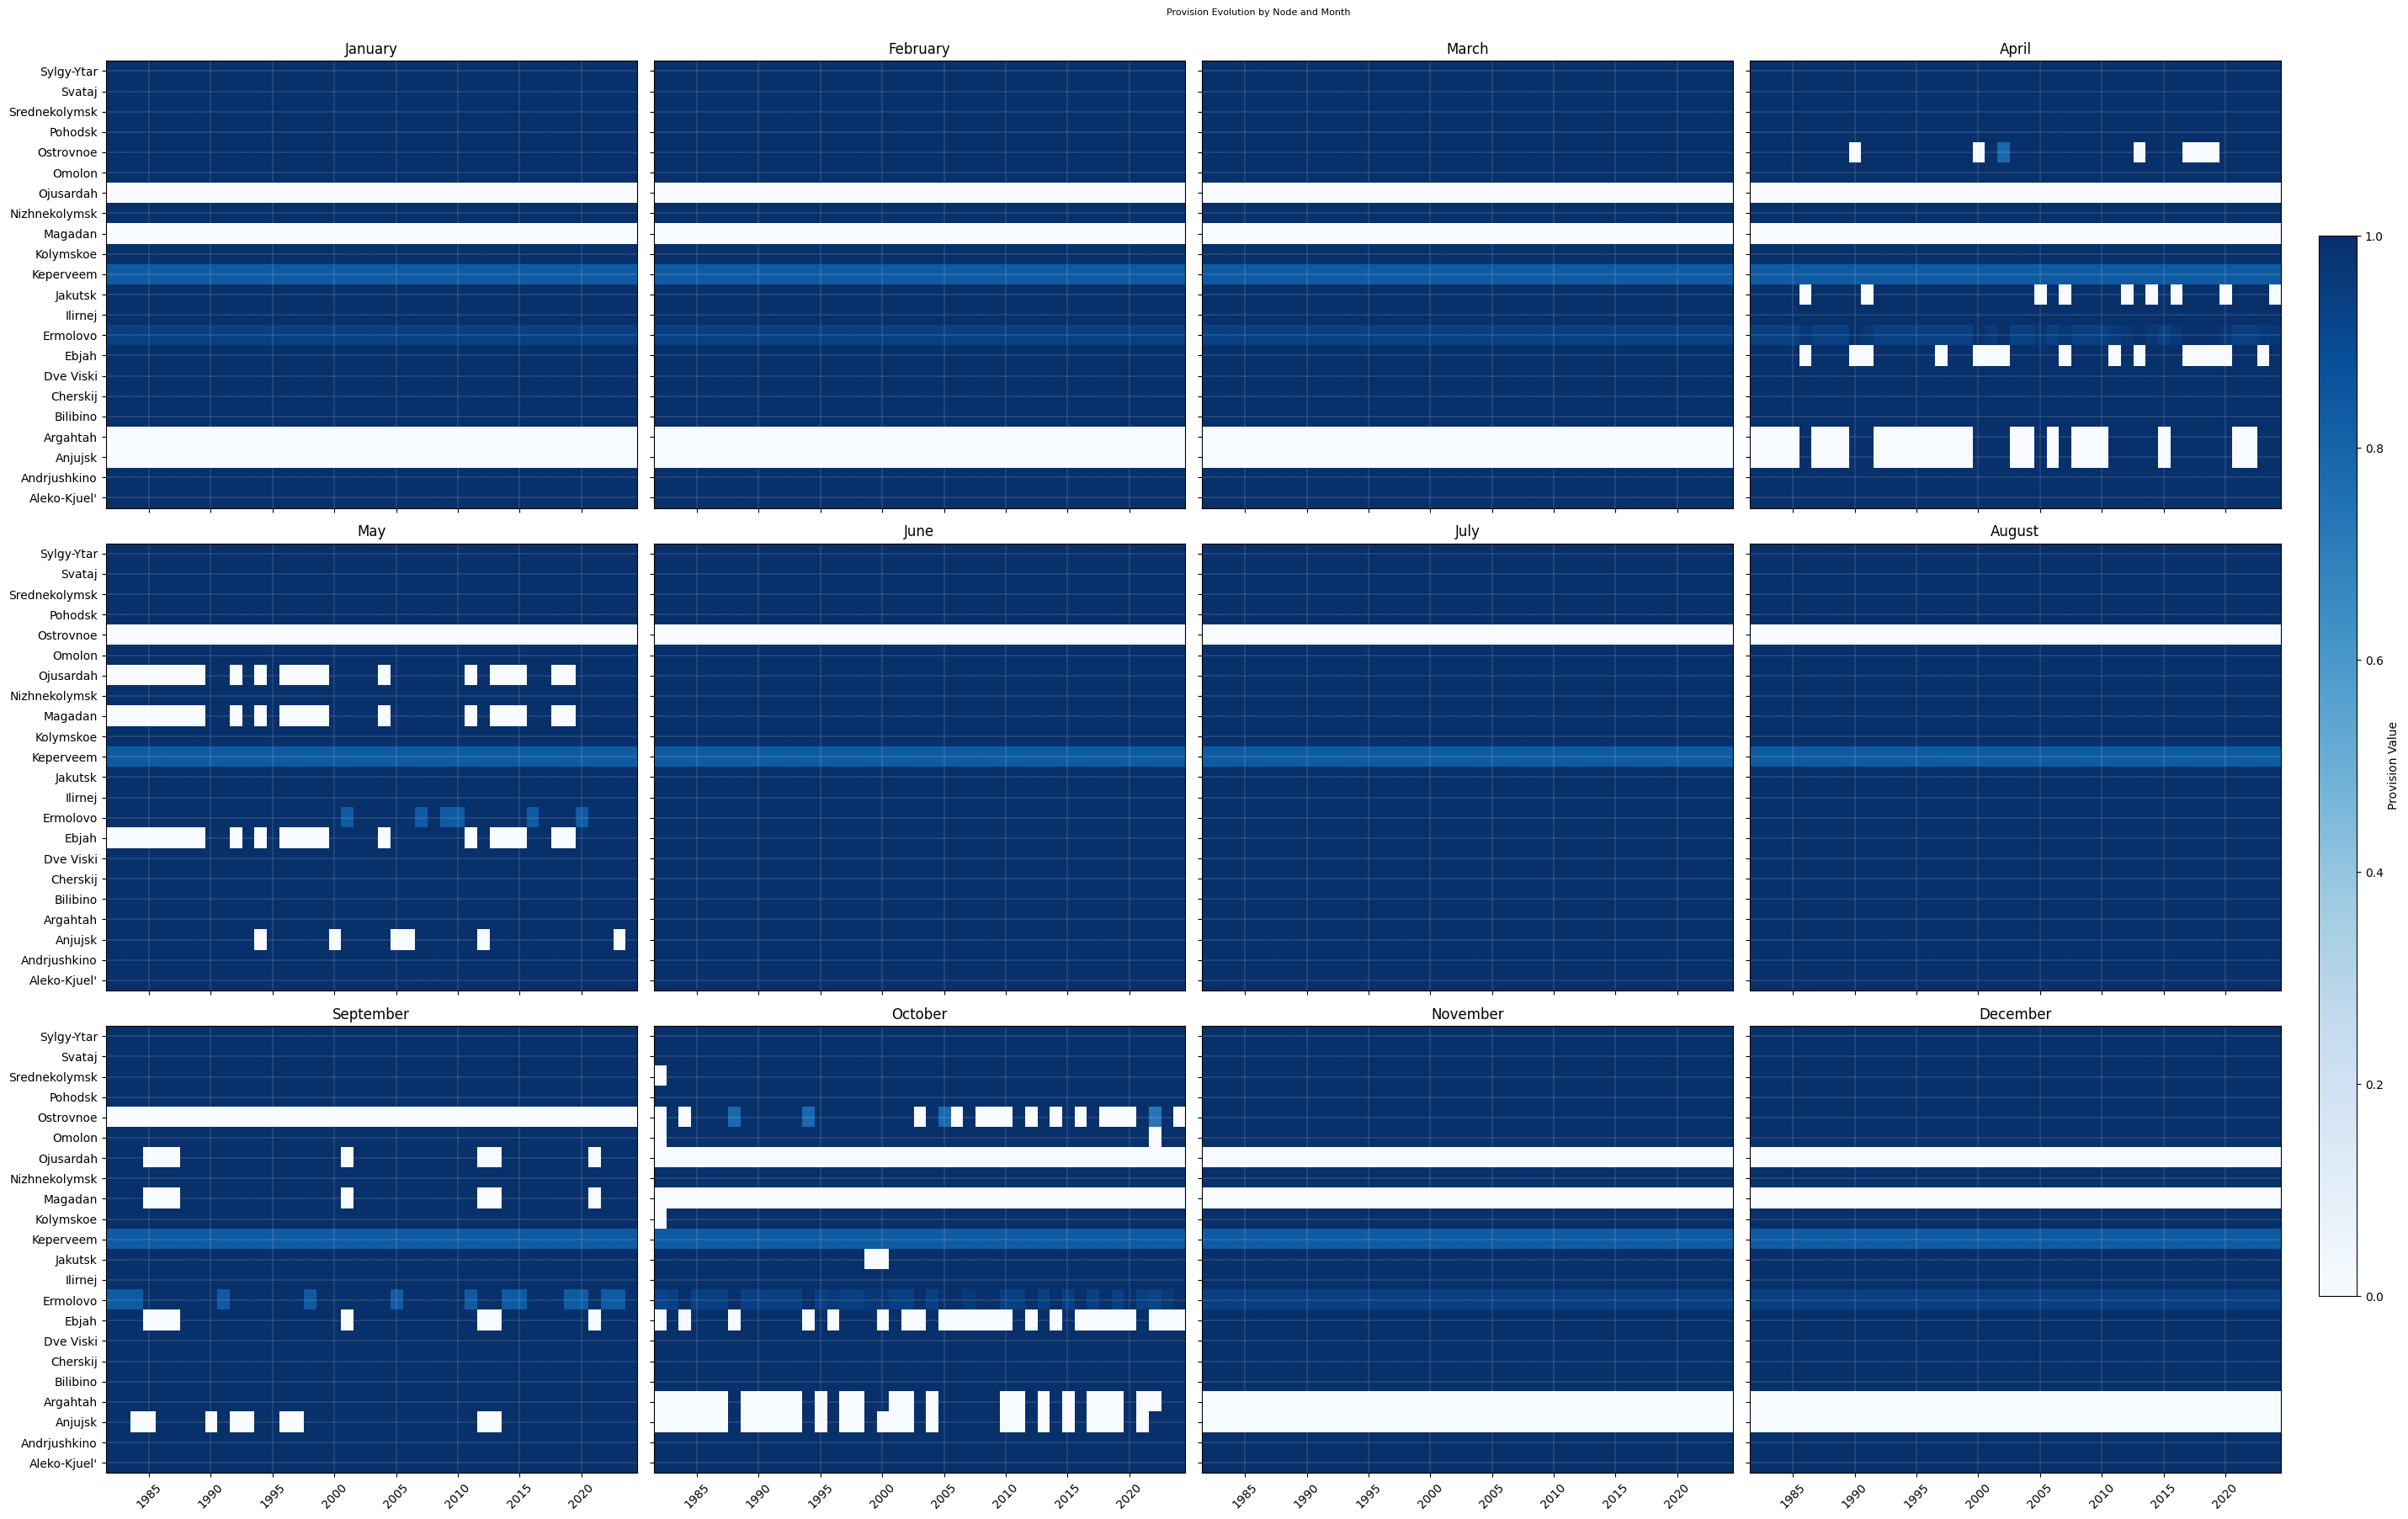

In [ ]:
def plot_provision_evolution_by_node(results, start_year=2025, figsize=(30, 18)):
    """
    Plot provision changes over time for each node, separated by month.

    Parameters:
        results: List of DataFrames (one per timestep) with columns ['name', 'provision']
        start_year: Year of first timestep
        figsize: Size of entire plot grid
    """
    # Сбор имён нод
    node_names = sorted(
        {
            row["name"]
            for timestep in results
            for _, row in timestep.reset_index().iterrows()
        }
    )

    # Организация по месяцам
    monthly_data = {month: {name: [] for name in node_names} for month in range(12)}

    for i, timestep in enumerate(results):
        month = i % 12
        for _, row in timestep.reset_index().iterrows():
            monthly_data[month][row["name"]].append(row["provision"])

    # Сетка 3x4
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    month_names = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]

    for month in range(12):
        ax = axes[month // 4, month % 4]
        data = monthly_data[month]

        # Определяем число лет
        n_years = len(next(iter(data.values()), []))
        if n_years == 0:
            continue  # пропускаем пустые

        years = list(range(start_year, start_year + n_years))
        provision_matrix = np.array([data[node] for node in node_names])

        im = ax.imshow(
            provision_matrix,
            aspect="auto",
            cmap="Blues",
            extent=[years[0] - 0.5, years[-1] + 0.5, -0.5, len(node_names) - 0.5],
            vmin=0,
            vmax=1,
        )

        ax.set_title(month_names[month])
        ax.set_yticks(range(len(node_names)))
        ax.set_yticklabels(node_names if month % 4 == 0 else [])
        ax.tick_params(axis="x", rotation=45)

        if month < 8:
            ax.set_xticklabels([])

        ax.grid(True, which="major", color="w", linestyle="--", linewidth=0.2)

    # Цветовая шкала
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="Provision Value")

    fig.suptitle("Provision Evolution by Node and Month", fontsize=8, y=1)
    plt.tight_layout(rect=[0, 0, 0.91, 1])
    plt.show()


# Call the function with the results
plot_provision_evolution_by_node(net.stats.results, START_YEAR)


In [ ]:
# Предполагаем что индекс df_stats — это месяцы в виде `i` (0...len-1)
try:
    df_stats["Month"] = df_stats.index % MONTHS_IN_YEAR + 1
    df_stats["Year"] = START_YEAR + df_stats.index // MONTHS_IN_YEAR
except Exception:
    pass


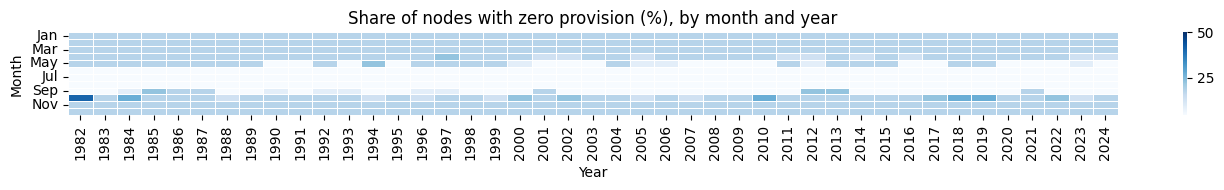

In [ ]:
def count_provision_zero_nonzero(results, start_year=1982):
    records = []

    for i, df in enumerate(results):
        year = start_year + (i // 12)
        month = (i % 12) + 1  # 1-12

        for _, row in df.reset_index().iterrows():
            records.append(
                {
                    "year": year,
                    "month": month,
                    "name": row["name"],
                    "provision": row["provision"],
                }
            )

    df_all = pd.DataFrame(records)
    df_all["is_non_zero"] = df_all["provision"] != 0
    df_all["month_name"] = pd.to_datetime(df_all["month"], format="%m").dt.strftime(
        "%b"
    )

    # Группировка
    counts = (
        df_all.groupby(["year", "month_name"])["is_non_zero"]
        .agg(non_zero="sum", total="count")
        .reset_index()
    )
    counts["zero"] = counts["total"] - counts["non_zero"]
    counts["zero_pct"] = 100 * counts["zero"] / counts["total"]

    # Упорядочим месяцы
    month_order = [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
    counts["month_name"] = pd.Categorical(
        counts["month_name"], categories=month_order, ordered=True
    )

    return counts


counts = count_provision_zero_nonzero(net.stats.results, start_year=START_YEAR)

# pivot_zero = counts.pivot(index="month_name", columns="year", values="zero")
pivot_zero_pct = counts.pivot(index="month_name", columns="year", values="zero_pct")

plt.figure(figsize=(14, 2))
sns.heatmap(
    pivot_zero_pct, cmap="Blues", linewidths=0.5, annot=False, fmt=".1f", vmax=50
)

plt.title("Share of nodes with zero provision (%), by month and year")
plt.xlabel("Year")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


In [ ]:
# Извлекаем размер времени
sample_node = list(G_undirected.nodes(data=True))[0]
T = sample_node[1]["temperature"].shape[0]
n_years = T // MONTHS_IN_YEAR
years = list(range(START_YEAR, START_YEAR + n_years))
months = list(range(1, MONTHS_IN_YEAR + 1))

records = []

for t in range(T):
    year = START_YEAR + (t // MONTHS_IN_YEAR)
    month = (t % MONTHS_IN_YEAR) + 1

    # Счётчики по каждому режиму
    mode_counts = {mode: 0 for mode in thresholds}

    for _, data in G_undirected.nodes(data=True):
        temp = data["temperature"].values[t]
        for mode, thresh in thresholds.items():
            if mode == "winter_tr" and temp < thresh:
                mode_counts[mode] += 1
            elif mode != "winter_tr" and temp > thresh:
                mode_counts[mode] += 1

    # Сохраняем
    for mode in thresholds:
        records.append(
            {
                "year": year,
                "month": month,
                "month_name": pd.to_datetime(str(month), format="%m").strftime("%b"),
                "mode": mode,
                "count": mode_counts[mode],
            }
        )

df_modes_monthly = pd.DataFrame(records)


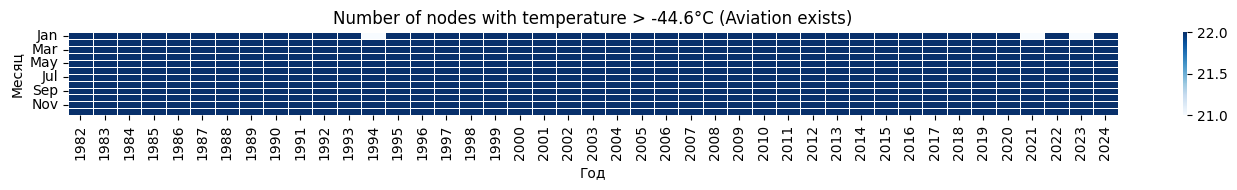

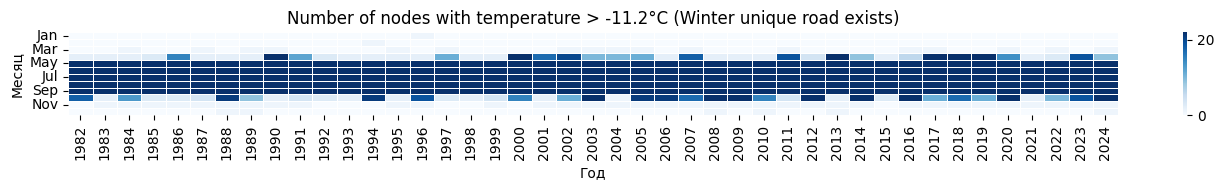

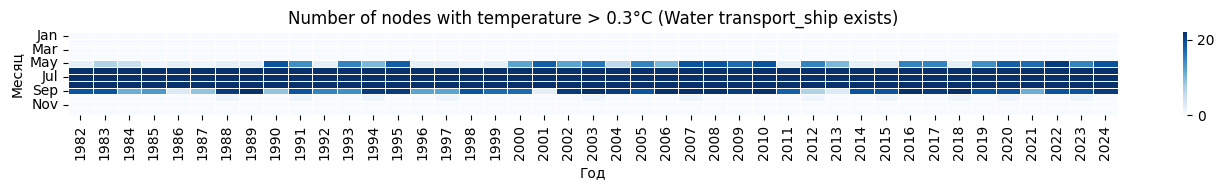

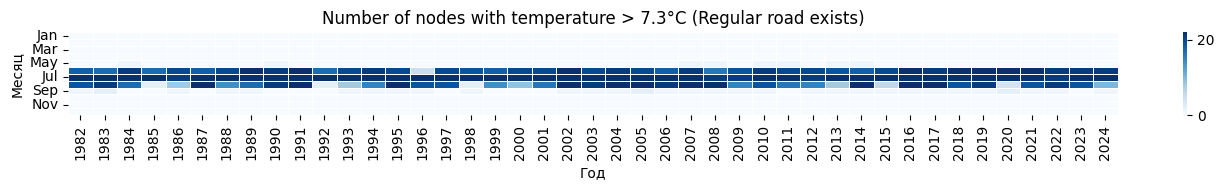

In [ ]:
df_modes_monthly["month_name"] = pd.Categorical(
    df_modes_monthly["month_name"], categories=month_order, ordered=True
)

# Фильтр по одному режиму
# mode = "car_warm"

for mode in thresholds:
    df_mode = df_modes_monthly[df_modes_monthly["mode"] == mode]
    pivot = df_mode.pivot(index="month_name", columns="year", values="count")

    plt.figure(figsize=(14, 2))
    sns.heatmap(
        pivot,
        cmap="Blues",
        linewidths=0.5,
    )

    sign = ">" if mode != "winter_tr" else "<"

    plt.title(
        f"Number of nodes with temperature {sign} {thresholds[mode]}°C ({mode} exists)"
    )
    plt.xlabel("Год")
    plt.ylabel("Месяц")
    plt.tight_layout()
    plt.show()


In [ ]:
"""
Гистограммы распределения времени по ребрам
 + относительно норматива по времени (для сервиса)
"""


'\nГистограммы распределения времени по ребрам\n + относительно норматива по времени (для сервиса)\n'

In [ ]:
"""
Хочется (однозначно) понять
как пропадают линки от температуры
Всм не картой сети а графиком
Где скажем есть какая-то температура например для ноды (в течение года(?))
И на ней же отмечено когда существует тип транспорта (или любой, или для этой ноды)
"""


'\nХочется (однозначно) понять\nкак пропадают линки от температуры\nВсм не картой сети а графиком\nГде скажем есть какая-то температура например для ноды (в течение года(?))\nИ на ней же отмечено когда существует тип транспорта (или любой, или для этой ноды)\n'

In [ ]:
"""
Хочется показать (при рассм одного сервиса)
Какие линки появляются *иногда* в зависимости от изменения температуры
Или наоборот исчезают (?)
"""


'\nХочется показать (при рассм одного сервиса)\nКакие линки появляются *иногда* в зависимости от изменения температуры\nИли наоборот исчезают (?)\n'

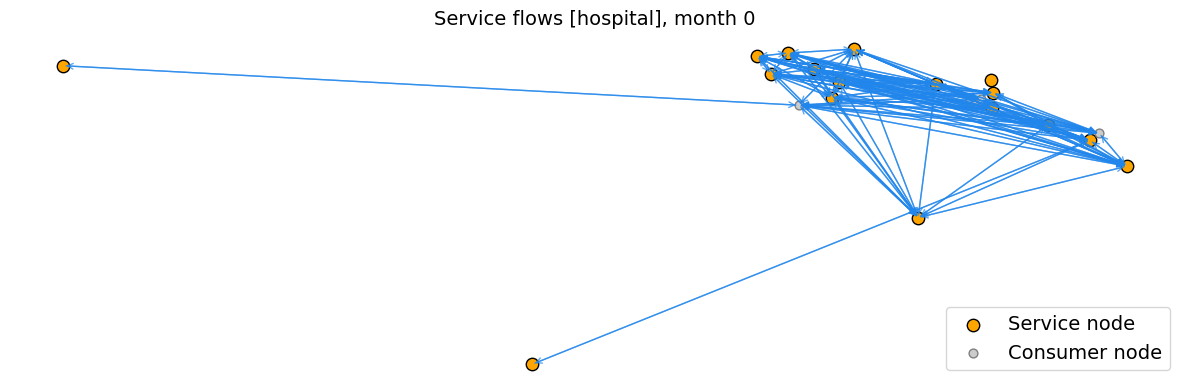

In [ ]:
def plot_service_flows_for_month(
    G, capacity_field="capacity_hospital", figsize=(12, 8), title=""
):
    pos = {n: (d["x"], d["y"]) for n, d in G.nodes(data=True)}

    # 1. Все сервисные ноды (capacity > 0)
    service_nodes = [n for n, d in G.nodes(data=True) if d.get(capacity_field, 0) > 0]
    # 2. Остальные — потребители
    consumer_nodes = [n for n in G.nodes() if n not in service_nodes]

    fig, ax = plt.subplots(figsize=figsize)

    # Рисуем ноды
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=service_nodes,
        node_color="orange",
        edgecolors="black",
        node_size=figsize[1] * 20,
        ax=ax,
        label="Service node",
    )
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=consumer_nodes,
        node_color="#cccccc",
        edgecolors="gray",
        node_size=figsize[1] * 10,
        ax=ax,
        label="Consumer node",
    )

    for u, v, data in G.edges(data=True):
        if data.get("transport_probability", 0) > 0:
            # if data.get("is_service_flow", False):
            ax.annotate(
                "",
                xy=pos[v],
                xycoords="data",
                xytext=pos[u],
                textcoords="data",
                arrowprops=dict(
                    arrowstyle="->", lw=figsize[1] / 4, color="#2186eb", alpha=0.72
                ),
                zorder=3,
            )

    ax.set_title(title, fontsize=14)
    ax.axis("off")
    ax.legend(loc="lower right", fontsize=14)
    plt.tight_layout()
    plt.show()


month_idx = 0
# Пример вызова для нужного месяца (граф берём из твоего net)
plot_service_flows_for_month(
    net.stats.graphs[month_idx],
    figsize=(12, 4),
    title=f"Service flows [{SERVICE_NAME}], month {month_idx}",
)


In [ ]:
# from collections import Counter, defaultdict
# import matplotlib.pyplot as plt
# import networkx as nx


# def edge_stability_over_years(
#     net, month_idx, service_name="hospital", figsize=(14, 4), freq=0.9
# ):
#     # 1. Соберём все графы этого месяца сквозь года
#     graphs = [
#         net.stats.graphs[i]
#         for i in range(month_idx, len(net.stats.graphs), MONTHS_IN_YEAR)
#     ]
#     years = [START_YEAR + i for i in range(len(graphs))]

#     # 2. Собираем частоты появления каждого сервисного ребра
#     edge_count = Counter()
#     edge_years = defaultdict(list)
#     for G, year in zip(graphs, years):
#         for u, v, data in G.edges(data=True):
#             if data.get("transport_probability", 0) > 0:
#                 # if data.get("is_service_flow", False):  # ⬅️ фильтрация!
#                 edge_count[(u, v)] += 1
#                 edge_years[(u, v)].append(year)

#     n_years = len(graphs)
#     # 3. Рассчитываем частоты (от 0 до 1)
#     edge_freq = {edge: count / n_years for edge, count in edge_count.items()}

#     # 4. Визуализация среднего графа
#     all_nodes = set()
#     for G in graphs:
#         all_nodes.update(G.nodes)
#     pos = {node: (G.nodes[node]["x"], G.nodes[node]["y"]) for node in all_nodes}

#     fig, ax = plt.subplots(figsize=figsize)

#     service_nodes = [
#         n
#         for n in all_nodes
#         if any(G.nodes[n].get(f"capacity_{service_name}", 0) > 0 for G in graphs)
#     ]
#     consumer_nodes = list(set(all_nodes) - set(service_nodes))

#     nx.draw_networkx_nodes(
#         G,
#         pos,
#         nodelist=consumer_nodes,
#         node_color="lightgray",
#         node_size=80,
#         alpha=0.8,
#         ax=ax,
#     )
#     nx.draw_networkx_nodes(
#         G,
#         pos,
#         nodelist=service_nodes,
#         node_color="orange",
#         node_size=120,
#         edgecolors="black",
#         linewidths=1.5,
#         ax=ax,
#     )

#     for (u, v), f in edge_freq.items():
#         color = "tab:blue" if f > freq else "crimson"
#         ax.plot(
#             [pos[u][0], pos[v][0]],
#             [pos[u][1], pos[v][1]],
#             color=color,
#             linewidth=0.5,
#         )

#     import matplotlib.patches as mpatches

#     ax.legend(
#         handles=[
#             mpatches.Patch(color="tab:blue", label=f"Stable link (>{100*freq:.0f}%)"),
#             mpatches.Patch(color="crimson", label=f"Unstable link (<={100*freq:.0f}%)"),
#             mpatches.Patch(color="orange", label="Service node"),
#             mpatches.Patch(color="lightgray", label="Consumer node"),
#         ],
#         loc="lower left",
#     )

#     ax.set_title(
#         f"Стабильность сервисных связей — {month_idx+1}-й месяц (сквозь года)",
#         fontsize=16,
#     )
#     ax.axis("off")
#     plt.tight_layout()
#     plt.show()

#     # Возвращаем нестабильные рёбра (по сервисному потоку)
#     rare_edges = {
#         edge: sorted(edge_years[edge]) for edge, f in edge_freq.items() if f <= freq
#     }

#     return rare_edges, edge_years


# for m in range(MONTHS_IN_YEAR):
#     rare_links, edge_years = edge_stability_over_years(net, month_idx=m, freq=0.5)
#     for edge, years in rare_links.items():
#         print(f"Edge {edge} appeared in years: {years}")


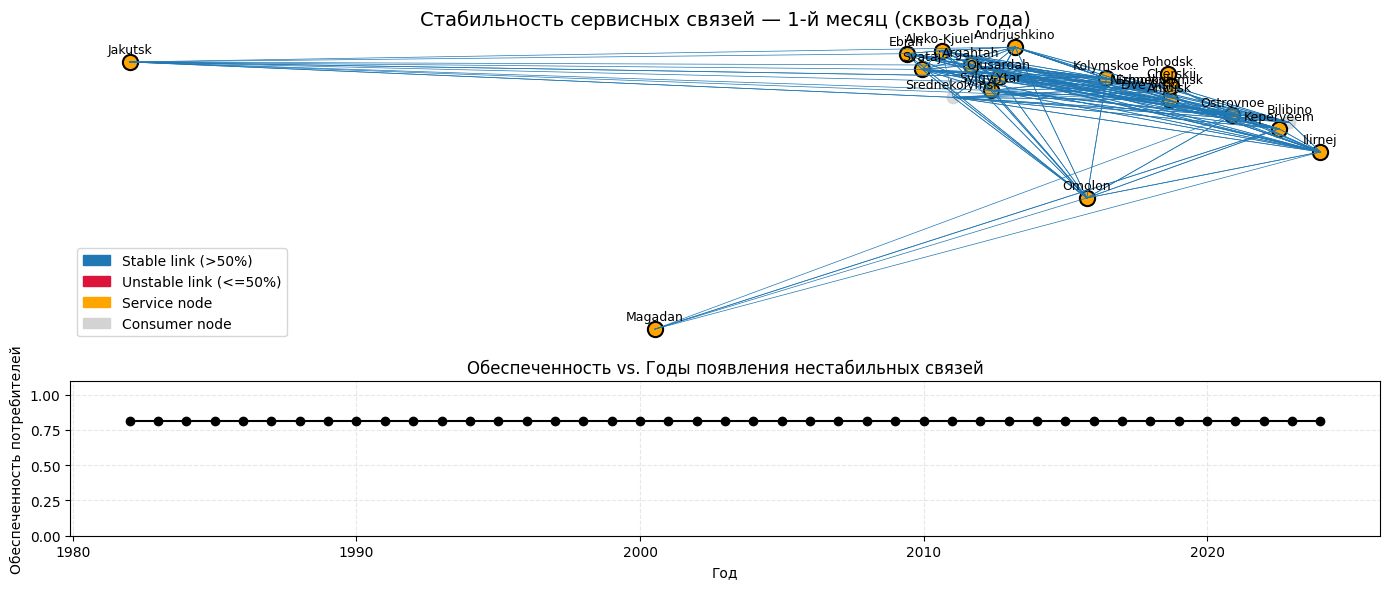

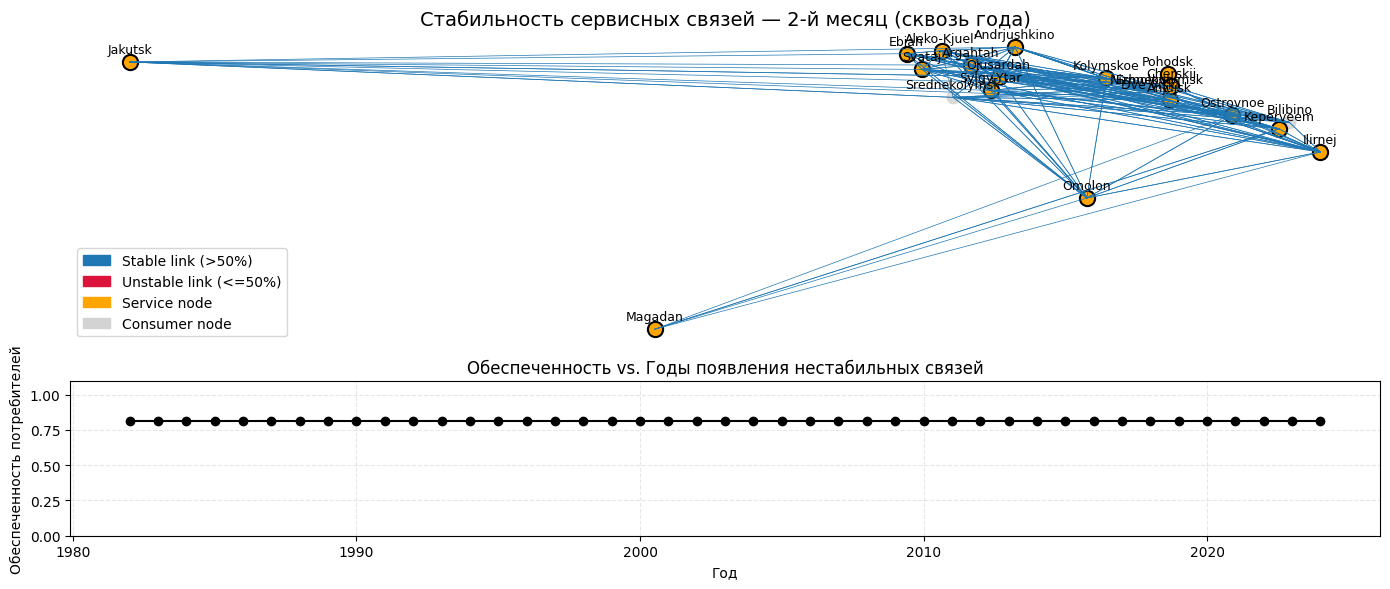

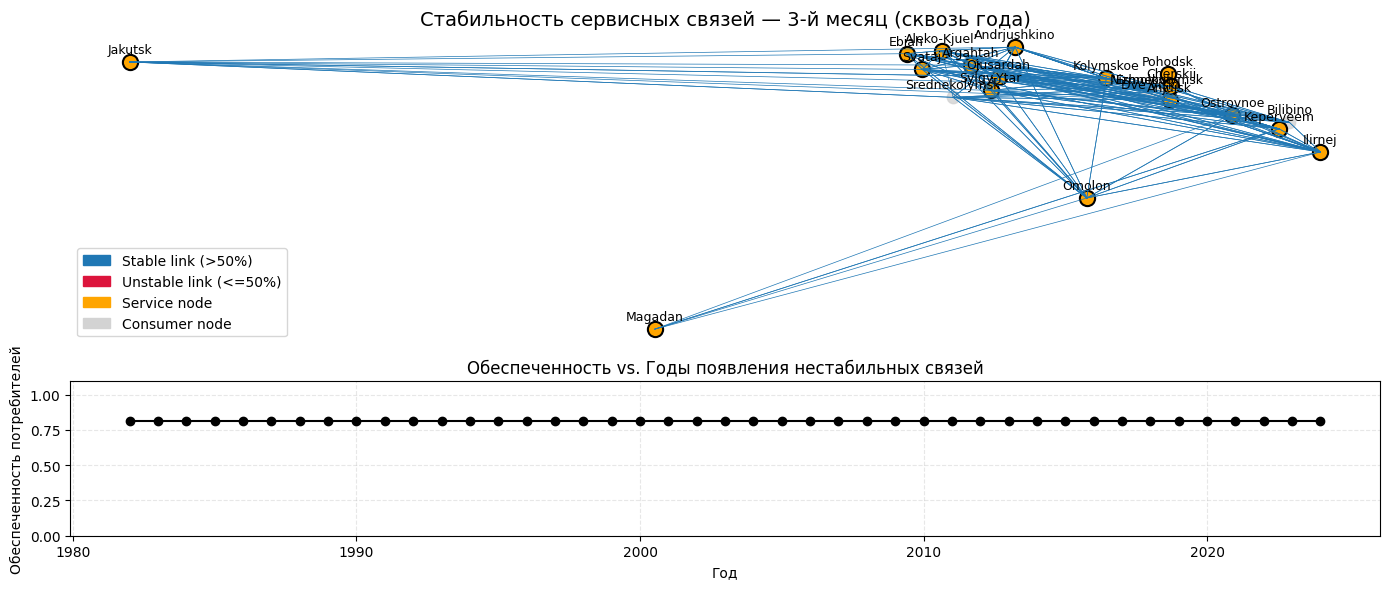

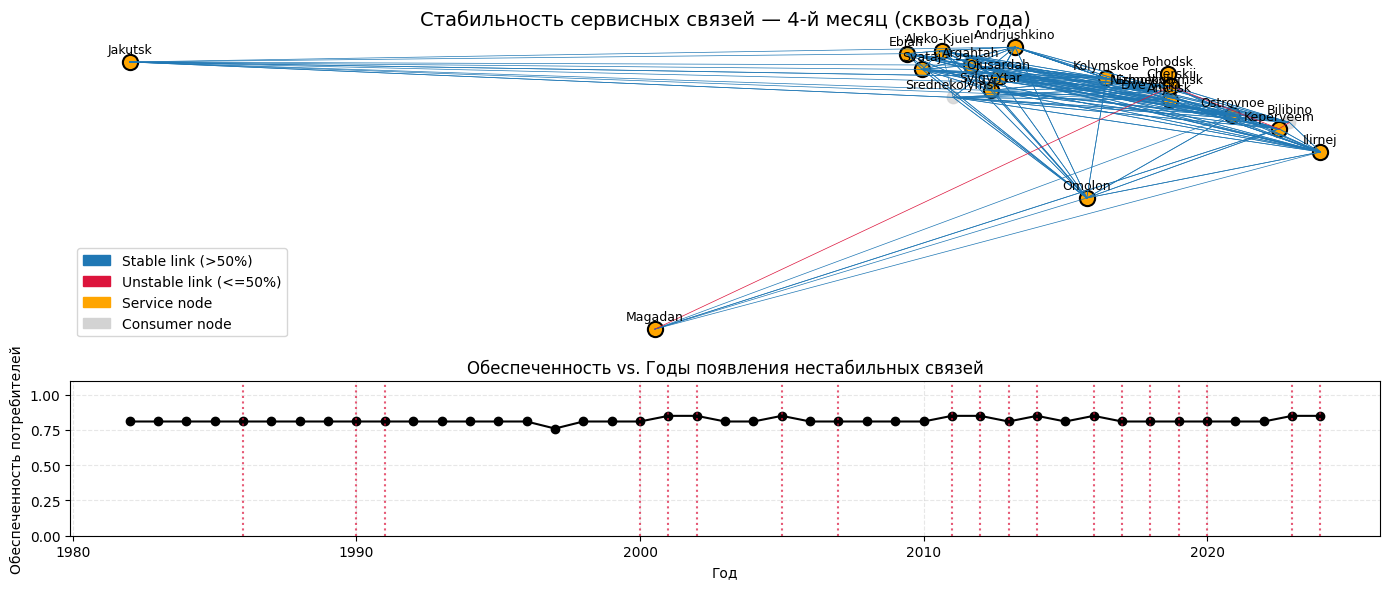

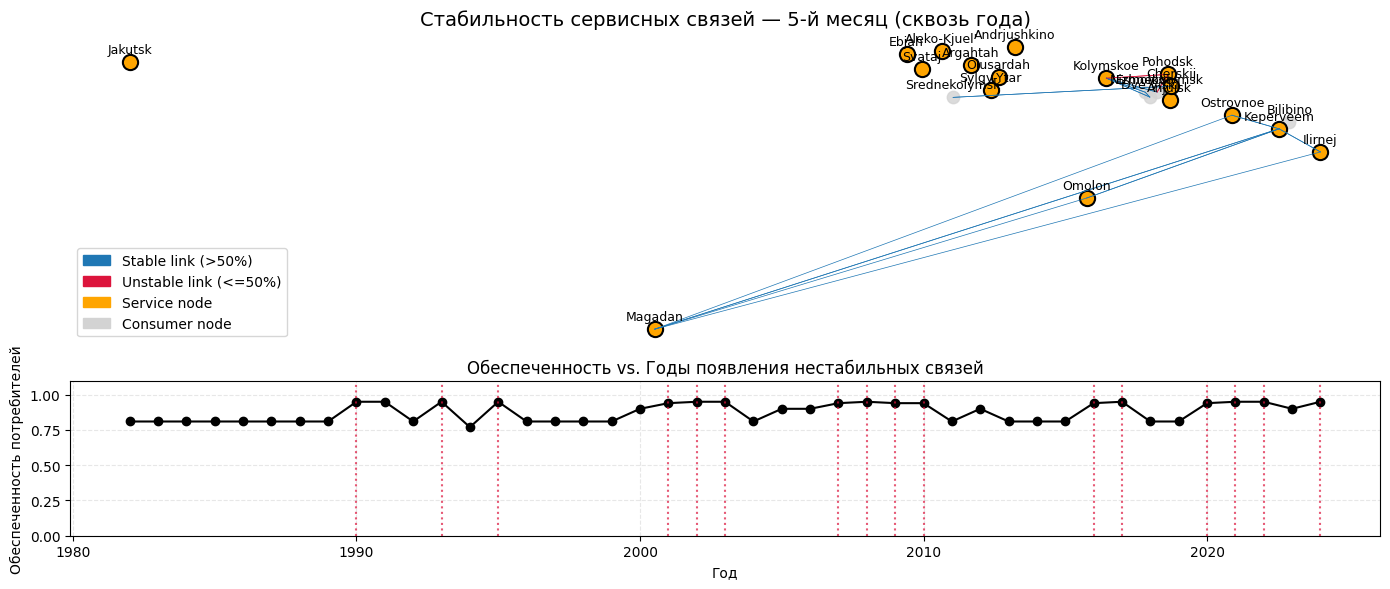

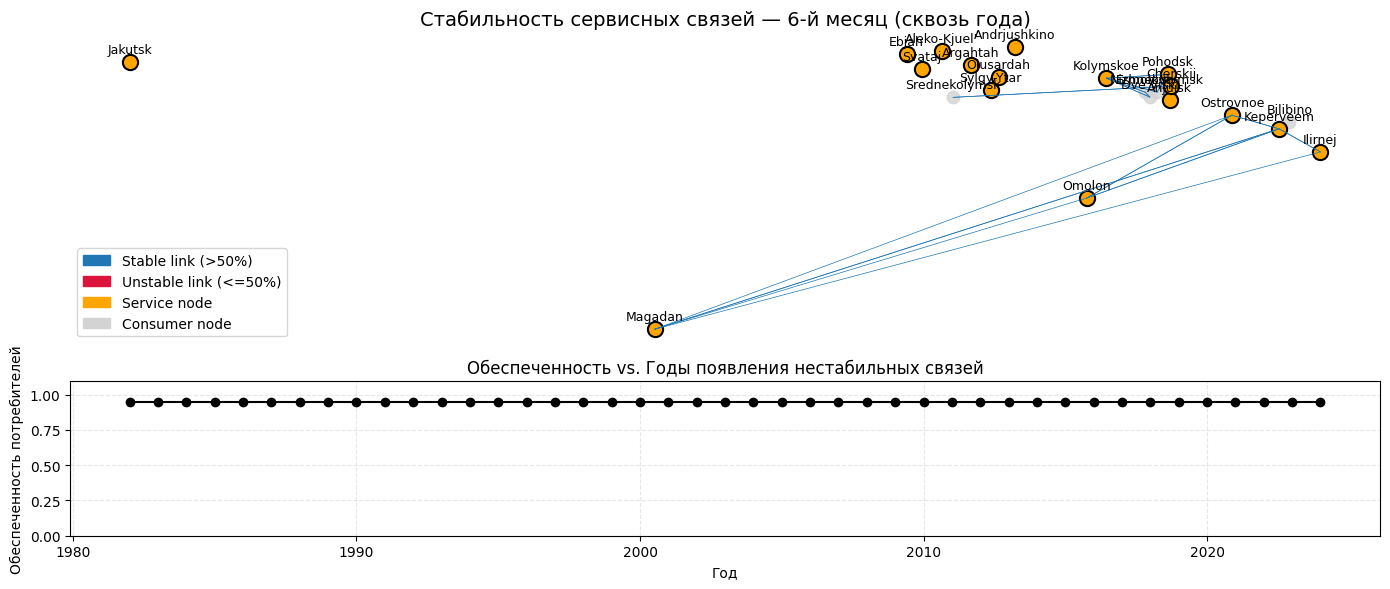

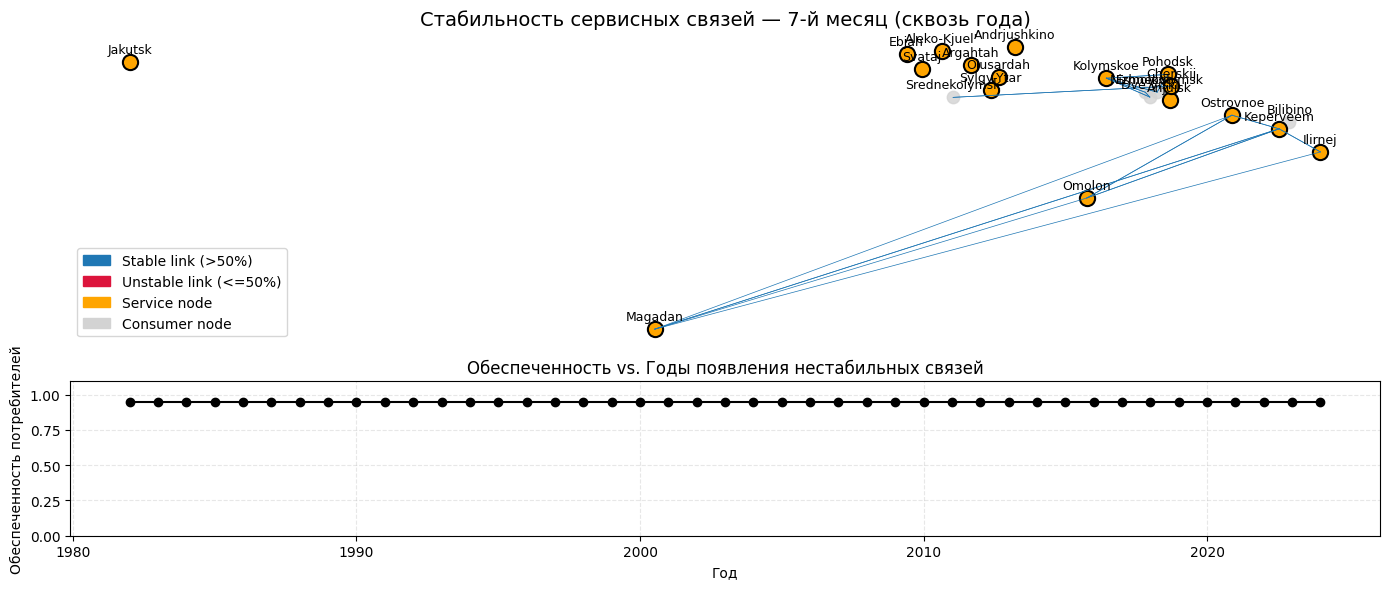

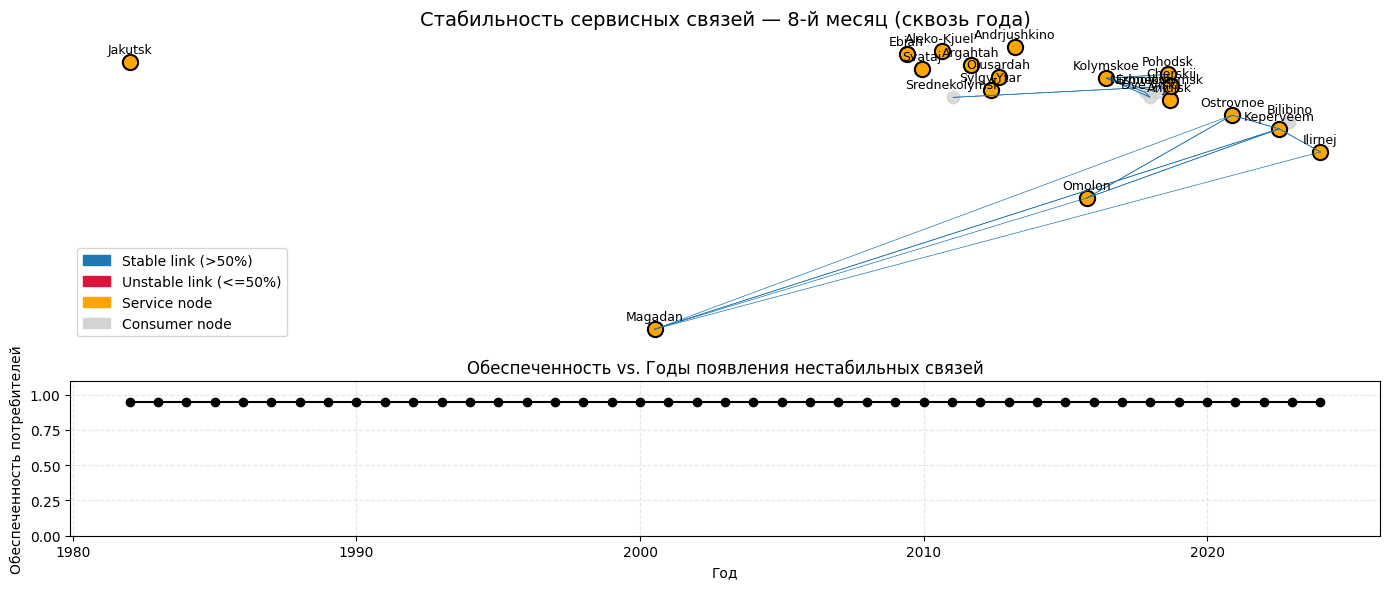

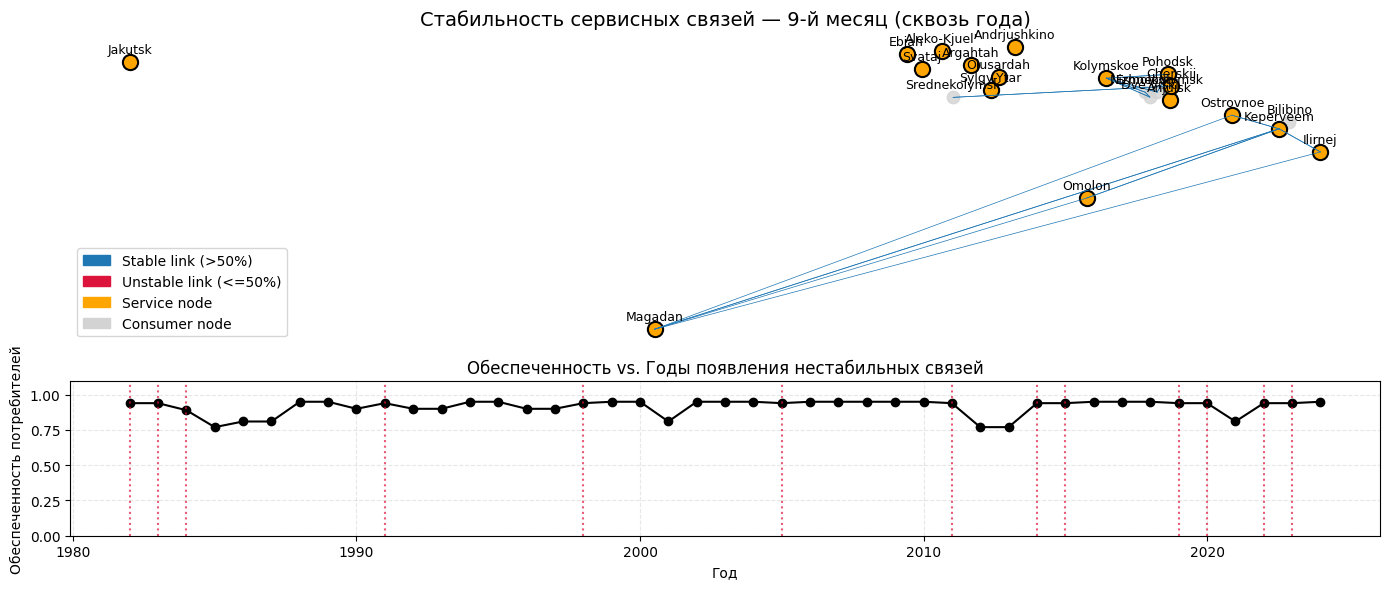

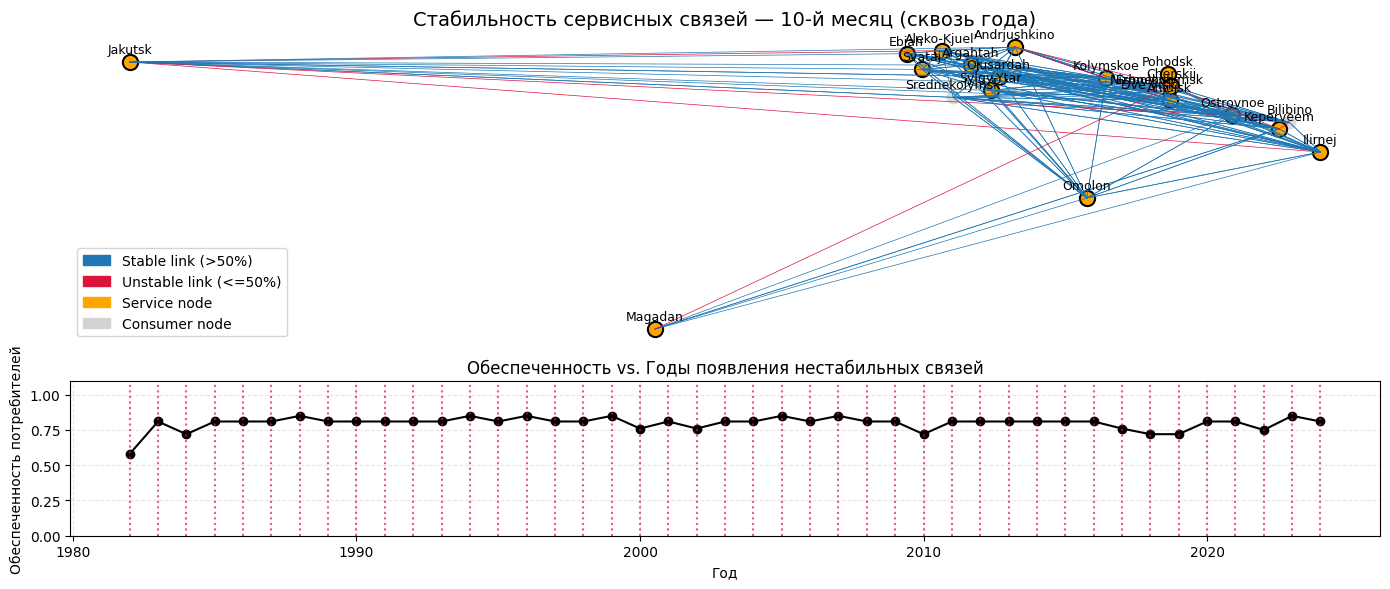

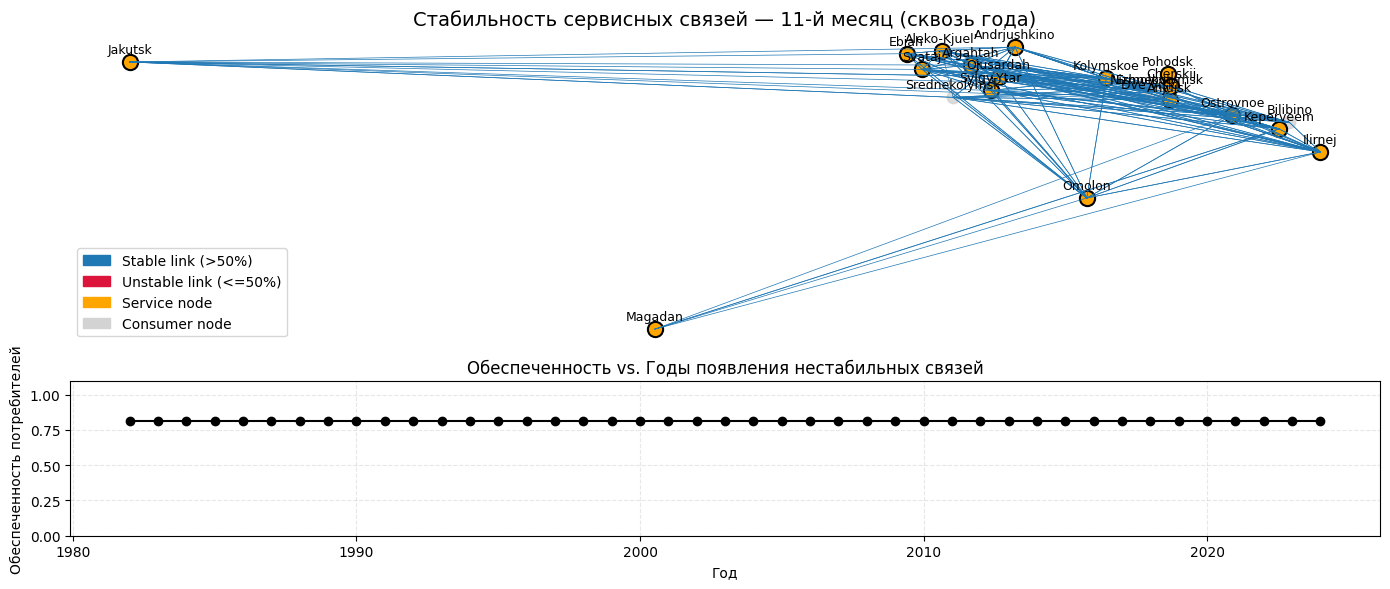

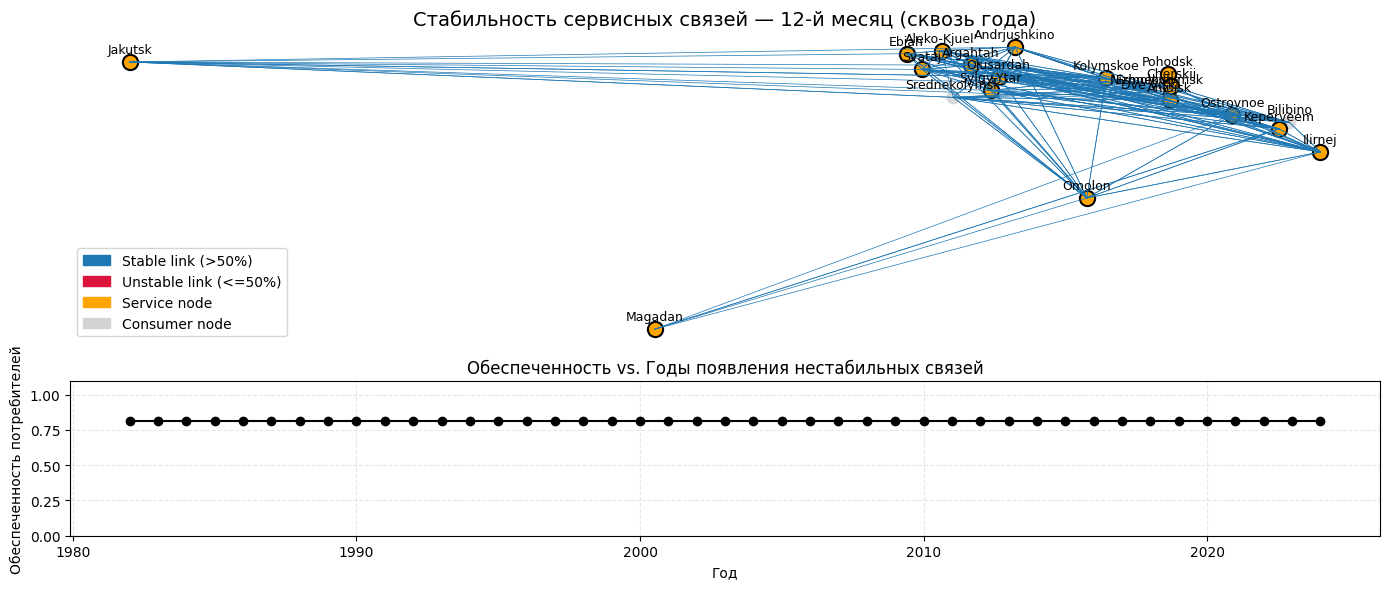

In [ ]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx


def edge_stability_over_years(
    net, month_idx, service_name="hospital", figsize=(14, 6), freq=0.1
):
    graphs = [
        net.stats.graphs[i]
        for i in range(month_idx, len(net.stats.graphs), MONTHS_IN_YEAR)
    ]
    years = [1982 + i for i in range(len(graphs))]

    edge_count = Counter()
    edge_years = defaultdict(list)
    for G, year in zip(graphs, years):
        for u, v, data in G.edges(data=True):
            if data.get("is_service_flow", True):
                # if data.get("transport_probability", 0) > 0:
                edge_count[(u, v)] += 1
                edge_years[(u, v)].append(year)

    n_years = len(graphs)
    edge_freq = {edge: count / n_years for edge, count in edge_count.items()}
    rare_edges = {
        edge: sorted(edge_years[edge]) for edge, f in edge_freq.items() if f <= freq
    }

    # Соберём список годов, где есть хотя бы одно редкое ребро
    years_with_rare = sorted({y for years in rare_edges.values() for y in years})
    # years_without_rare = [y for y in years if y not in years_with_rare]

    def compute_provision(G, service_name):
        consumers = [
            n
            for n, d in G.nodes(data=True)
            if d.get(f"capacity_{service_name}", 0) == 0
        ]
        prov_values = [
            G.nodes[n].get(f"provision_{service_name}", 0.0) for n in consumers
        ]
        if not prov_values:
            return 0.0
        return sum(prov_values) / len(prov_values)

    provision_series = (
        net.stats.records.query(f"Month == {month_idx+1}")
        .set_index("Year")["mean"]
        .to_dict()
    )

    # ─────── 📌 Визуализация ─────── #
    all_nodes = set()
    for G in graphs:
        all_nodes.update(G.nodes)
    pos = {node: (G.nodes[node]["x"], G.nodes[node]["y"]) for node in all_nodes}

    fig, (ax_net, ax_plot) = plt.subplots(
        2, 1, figsize=figsize, gridspec_kw={"height_ratios": [2, 1]}
    )

    service_nodes = [
        n
        for n in all_nodes
        if any(G.nodes[n].get(f"capacity_{service_name}", 0) > 0 for G in graphs)
    ]
    consumer_nodes = list(set(all_nodes) - set(service_nodes))

    G0 = graphs[0]  # просто для node атрибутов
    nx.draw_networkx_nodes(
        G0,
        pos,
        nodelist=consumer_nodes,
        node_color="lightgray",
        node_size=80,
        alpha=0.8,
        ax=ax_net,
    )
    nx.draw_networkx_nodes(
        G0,
        pos,
        nodelist=service_nodes,
        node_color="orange",
        node_size=120,
        edgecolors="black",
        linewidths=1.5,
        ax=ax_net,
    )

    for node, (x, y) in pos.items():
        name = G0.nodes[node].get("name", str(node))
        ax_net.text(
            x,
            y + 20000,  # смещение вверх, подбери по масштабу графа
            name,
            fontsize=9,
            ha="center",
            va="bottom",
            zorder=3,
        )

    for (u, v), f in edge_freq.items():
        color = "tab:blue" if f > freq else "crimson"
        ax_net.plot(
            [pos[u][0], pos[v][0]],
            [pos[u][1], pos[v][1]],
            color=color,
            linewidth=0.5,
        )

    import matplotlib.patches as mpatches

    ax_net.legend(
        handles=[
            mpatches.Patch(color="tab:blue", label=f"Stable link (>{100*freq:.0f}%)"),
            mpatches.Patch(color="crimson", label=f"Unstable link (<={100*freq:.0f}%)"),
            mpatches.Patch(color="orange", label="Service node"),
            mpatches.Patch(color="lightgray", label="Consumer node"),
        ],
        loc="lower left",
    )
    ax_net.set_title(
        f"Стабильность сервисных связей — {month_idx+1}-й месяц (сквозь года)",
        fontsize=14,
    )
    ax_net.axis("off")

    # ─────── 📈 График обеспеченности ───────
    ax_plot.plot(
        provision_series.keys(), provision_series.values(), marker="o", color="black"
    )
    ax_plot.set_ylabel("Обеспеченность потребителей")
    ax_plot.set_xlabel("Год")
    ax_plot.set_ylim(0, 1.05)
    ax_plot.grid(True, linestyle="--", alpha=0.3)

    for year in years_with_rare:
        ax_plot.axvline(x=year, color="crimson", linestyle=":", alpha=0.7)

    ax_plot.set_title(
        "Обеспеченность vs. Годы появления нестабильных связей", fontsize=12
    )
    plt.ylim((0.0, 1.1))
    plt.tight_layout()
    plt.show()

    return rare_edges, provision_series


for m in range(12):
    rare_links, provision = edge_stability_over_years(net, month_idx=m, freq=0.5)


# -- Stop here --

# Выводы (вопросы Любы)

### 1.  prediction of network node attributes (provision type etc.) given structural network node properties (betweenness measures)

In [ ]:
"""
Нет
"""


### 2.  we can represent the network of connectivity between cities  as multilayed network (structuring it by node attributes or by link types), this representation is an alternative  representation of seasonal  data as network structures

In [ ]:
"""
снова по типам ребер? Ну хз скорее нет
"""


### 3. Main (hub "опорные") cities selection based on the connectivity types. Depending on the connectivity type we can get separate main hub cities.

In [ ]:
"""
- выделение хабов по разным типам транспорта
-- маршруты через эти хабы
"""


### 4. Characterisation of critical moments (given structural and node attribute properties). How to distinguish them using network analysis (solely) ?

In [ ]:
"""
- Перечислить что есть эти критичные моменты (без нетворк саенс)
- Перечислить что есть эти критичные моменты (с нетворк саенс)
"""
